# Earth quake
> graph laplacian

- toc:true
- branch: master
- badges: true
- comments: false
- author: 최서연
- categories: [Graph Laplacian, PCA]

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import networkx as nx

In [2]:
df=pd.read_csv('https://raw.githubusercontent.com/plotly/datasets/master/earthquakes-23k.csv')
df

,Date,Latitude,Longitude,Magnitude
0,01/02/1965,19.2460,145.6160,6.0
1,01/04/1965,1.8630,127.3520,5.8
2,01/05/1965,-20.5790,-173.9720,6.2
3,01/08/1965,-59.0760,-23.5570,5.8
4,01/09/1965,11.9380,126.4270,5.8
...,...,...,...,...
23407,12/28/2016,38.3917,-118.8941,5.6
23408,12/28/2016,38.3777,-118.8957,5.5
23409,12/28/2016,36.9179,140.4262,5.9
23410,12/29/2016,-9.0283,118.6639,6.3


In [3]:
# df.assign 임시 데이터 만들어줘서 원래 데이터 안 건들이게
lst=[df.assign(Year=list(map(lambda x: x.split('/')[-1], df.Date))).\
groupby('Year').\
pipe(list)[i][1].iloc[:,[1,2,3]].\
to_numpy().tolist() for i in range(2017-1965)]

pipe는 튜플로 묶여 있어서 [][] 해줘야 데이터프레임으로 나오지

한 번에 list로 안 되어서 numpy 해준 후 list

`-` 숙제: 

지진자료에서 1985년 이후의 자료만 고른뒤에 HeatMapWithTime()을 이용하여 시각화하라.

In [4]:
lst2=[df.assign(Year=list(map(lambda x: x.split('/')[-1], df.Date))).query('Year>="1985"').\
groupby('Year').\
pipe(list)[i][1].iloc[:,[1,2,3]].\
to_numpy().tolist() for i in range(2016-1985)]

- t = Year
- x = Latitude
- y = Longitude
- f = Magnitude

1. 데이터 정의

In [5]:
_df = df.assign(Year=list(map(lambda x: x.split('/')[-1], df.Date))).query('Year>="2015"').reset_index().iloc[:,1:]
_df

,Date,Latitude,Longitude,Magnitude,Year
0,01/02/2015,6.5739,60.3653,5.5,2015
1,01/05/2015,-43.0546,171.2364,5.6,2015
2,01/06/2015,55.2049,163.2446,5.6,2015
3,01/07/2015,5.9045,-82.6576,6.5,2015
4,01/08/2015,-61.6118,161.3346,5.7,2015
...,...,...,...,...,...
910,12/28/2016,38.3917,-118.8941,5.6,2016
911,12/28/2016,38.3777,-118.8957,5.5,2016
912,12/28/2016,36.9179,140.4262,5.9,2016
913,12/29/2016,-9.0283,118.6639,6.3,2016


2. 실제 $f(x) = y$ 정의
- $y$ = Magnitude,  지진 강도로 정의

In [171]:
f_true = _df.loc[:,"Magnitude"]

In [172]:
f = f_true + np.random.normal(scale=0.2,size=len(f_true))

In [173]:
f.shape

(915,)

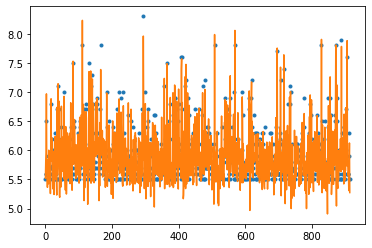

In [174]:
plt.plot(f_true,'.')
plt.plot(f,'-')

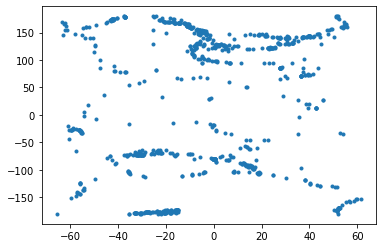

In [203]:
plt.plot( _df.Latitude,_df.Longitude,'.')

3. $(x_i,y_i)$와 $(x_j,y_j)$ 사이의 유클리드 거리 정의
- $x$ = Latitude, 위도로 정의
- $y$ = Longitude, 경도로 정의
    - 반대편으로 갈 수 있는 경우 반대편 각을 구하기 위하여 경도 차이의 절대값이 180을 넘는 경우 360을 빼주는 조건 추가

$$dist((x_i,y_i),(x_j,y_j)) = \sqrt{((x_j-x_i)^2-(y_j-y_i)^2}$$

In [176]:
def dist(i,j):
    if abs( _df.Longitude[j] - _df.Longitude[i] ) >= 180: 
        return np.sqrt( ( ( _df.Latitude[j] - _df.Latitude[i] )**2) + ( ( _df.Longitude[j] - _df.Longitude[i] -360)**2) )  
    else:
        return np.sqrt( ( ( _df.Latitude[j] - _df.Latitude[i] )**2) + ( ( _df.Longitude[j] - _df.Longitude[i])**2) )

4. 거리를 이용한 $W_{i,j}$ 행렬 정의
- a weighted adjacency matrix $W$
- 동일한 지점 상의 거리는 0이 되어 w가 1이 될 것이다(대각행렬은 모두 1이 될터.)

$$W_{i,j}=\begin{cases}{exp(-\frac{[dist(i,j)]^2}{2\theta^2})} & \quad \text{if } dist(i,j) \leq κ \\ 0 & \quad \text{otherwise} \end{cases}$$

In [177]:
def weight(i,j,theta=10,kappa=100):
    return np.exp( -np.abs(dist(i,j))**2 / (2*theta**2) ) if dist(i,j) <= kappa else 0

In [178]:
W = np.array([[weight(i,j) for i in range(len(_df))] for j in range(len(_df))])

In [206]:
W.round(3)

array([[1.   , 0.   , 0.   , ..., 0.   , 0.   , 0.   ],
       [0.   , 1.   , 0.   , ..., 0.   , 0.   , 0.   ],
       [0.   , 0.   , 1.   , ..., 0.014, 0.   , 0.019],
       ...,
       [0.   , 0.   , 0.014, ..., 1.   , 0.   , 0.994],
       [0.   , 0.   , 0.   , ..., 0.   , 1.   , 0.   ],
       [0.   , 0.   , 0.019, ..., 0.994, 0.   , 1.   ]])

그래프(왜 실행할 때마다 같은 데이터에서 다른 그래프가 나올까.)

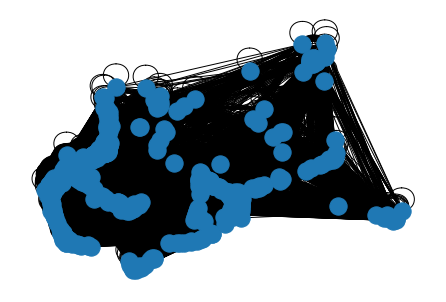

In [207]:
nx.draw(nx.Graph(W))

5. $W_{i,j}$ 행렬을 이용한 차수 행렬 정의
- $D$ = Degree Matrix

In [179]:
D = np.diag(W.sum(axis=1))

In [180]:
D

array([[ 3.65998438,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        , 41.99088651,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        , 15.66034464, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [ 0.        ,  0.        ,  0.        , ..., 56.79422334,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
        41.43859961,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        , 55.80166672]])

6. Graph Laplacian matrix 정의
- $L = D - W$

In [181]:
L = D - W

In [182]:
L

array([[ 2.65998438e+00,  0.00000000e+00,  0.00000000e+00, ...,
        -1.20783713e-16, -1.23355927e-08, -4.72126380e-17],
       [ 0.00000000e+00,  4.09908865e+01, -7.86860671e-22, ...,
        -1.12413695e-16, -3.04951206e-09, -1.03131967e-16],
       [ 0.00000000e+00, -7.86860671e-22,  1.46603446e+01, ...,
        -1.39055291e-02, -5.30939200e-14, -1.88878509e-02],
       ...,
       [-1.20783713e-16, -1.12413695e-16, -1.39055291e-02, ...,
         5.57942233e+01, -2.44062848e-06, -9.94026527e-01],
       [-1.23355927e-08, -3.04951206e-09, -5.30939200e-14, ...,
        -2.44062848e-06,  4.04385996e+01, -1.57119318e-06],
       [-4.72126380e-17, -1.03131967e-16, -1.88878509e-02, ...,
        -9.94026527e-01, -1.57119318e-06,  5.48016667e+01]])

7. 고유값 분해
- ${\bf L} = {\boldsymbol\Psi} {\boldsymbol\Lambda} {\boldsymbol\Psi}^\top$

In [183]:
λ, Ψ = np.linalg.eig(L)

In [184]:
Λ = np.diag(λ)

---

푸리에

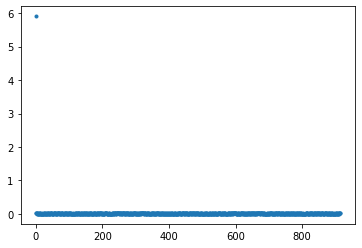

In [185]:
fbar = np.abs(np.fft.fft(f))/len(f)
plt.plot(fbar,'.')

In [186]:
fbar[0] 

5.907710032601912

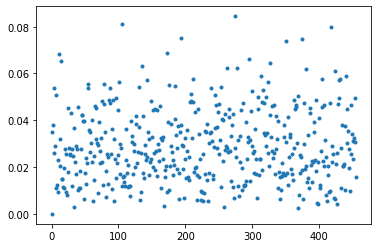

In [187]:
fbar2=np.zeros(456)
# fbar2[0] = fbar[0] 
fbar2[1:456] = 2*fbar[1:456]
plt.plot(fbar2,'.')

In [188]:
fbar2[:10]

array([0.        , 0.03486206, 0.03792581, 0.02620554, 0.05372515,
       0.02893896, 0.05076426, 0.01101211, 0.01247844, 0.02283055])

---

8. f $\times$ 고유벡터 외적한 값

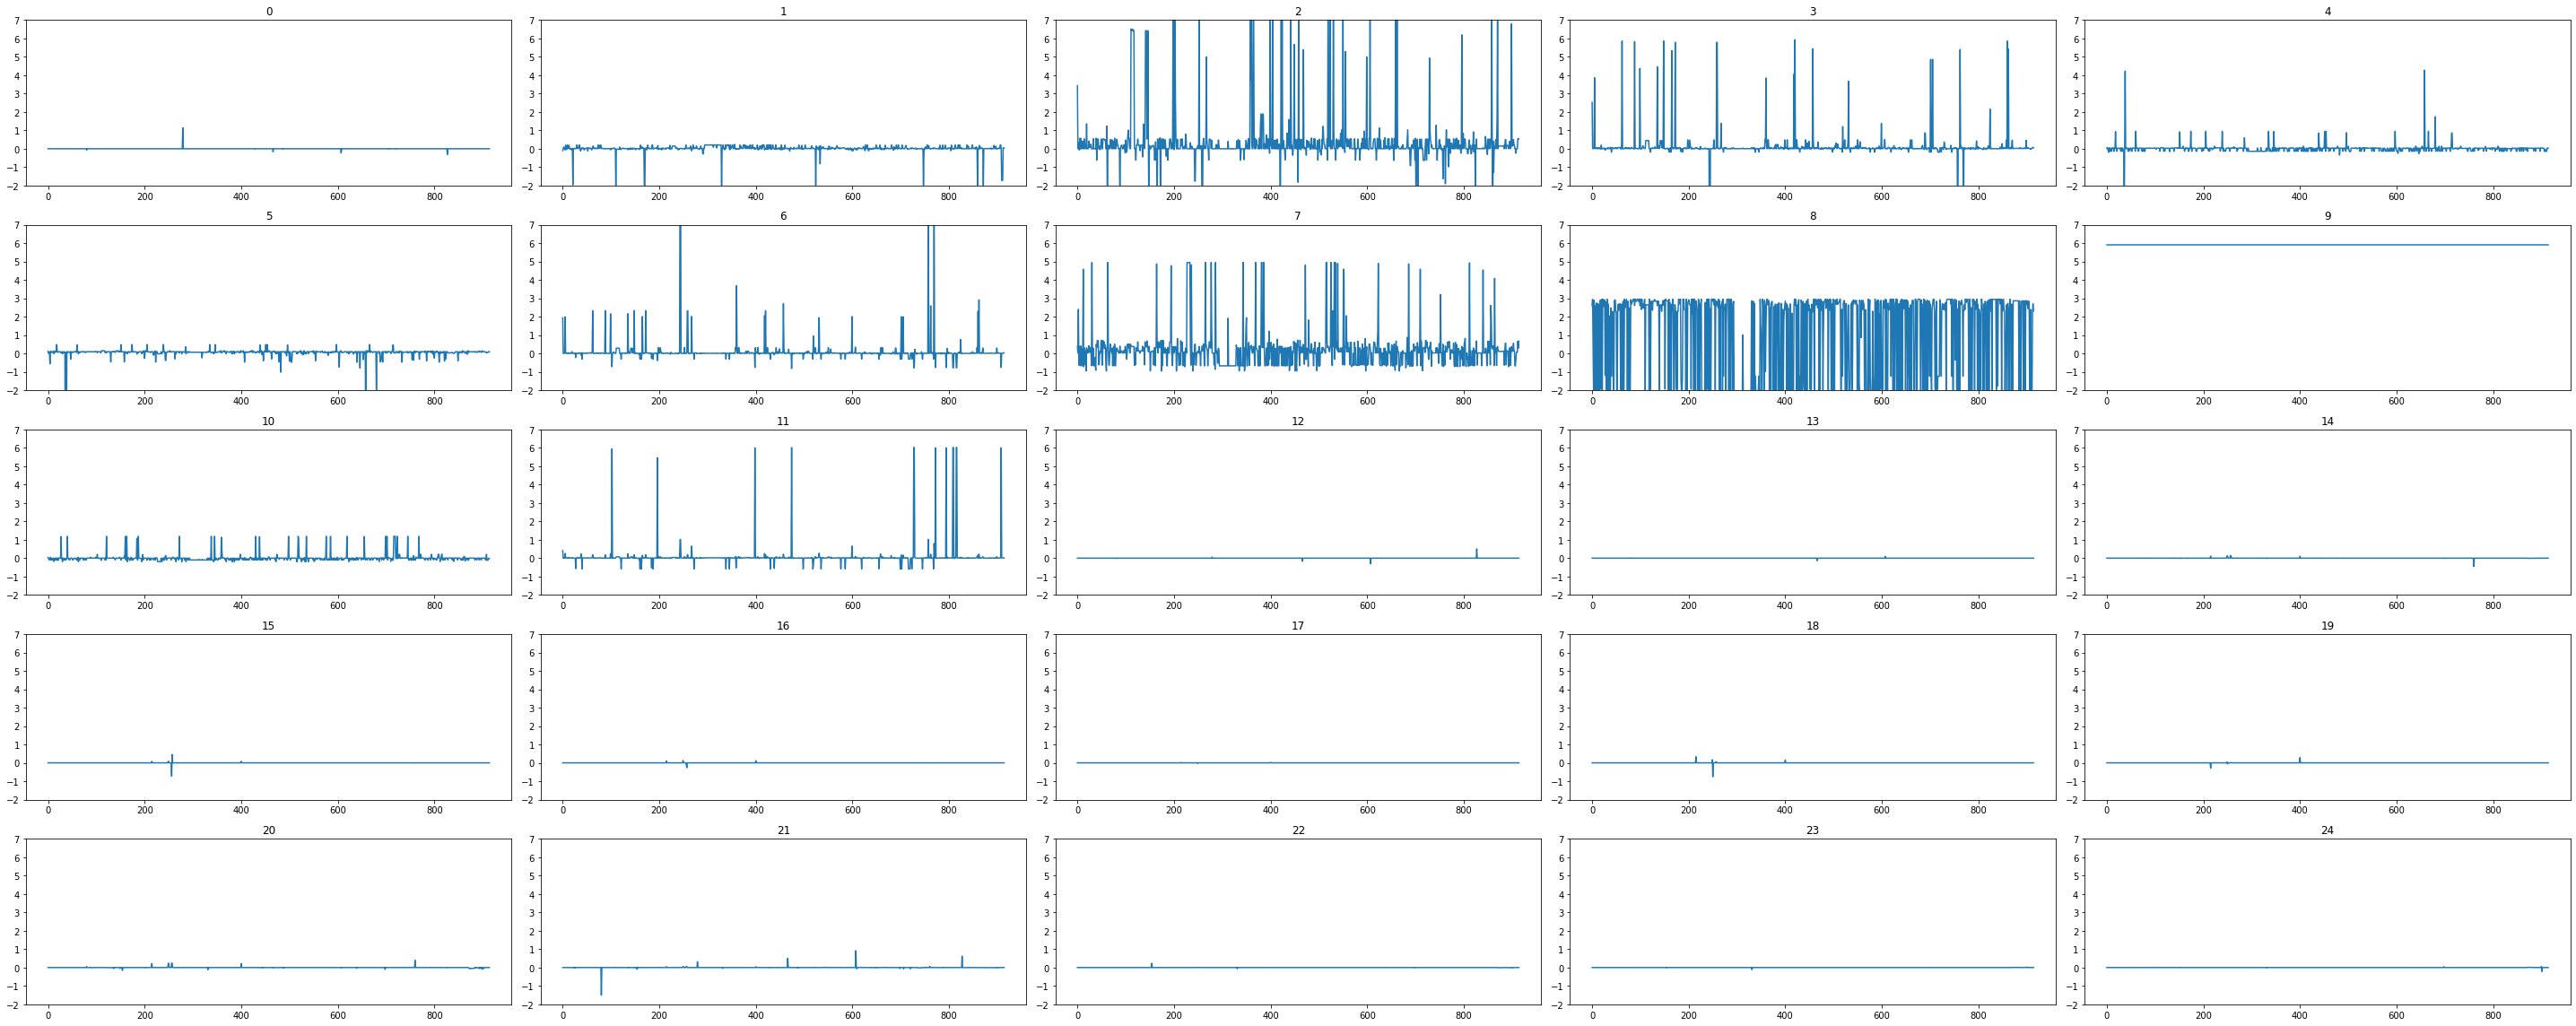

In [189]:
fig,ax =plt.subplots(5,5)
k=0
for i in range(5):
    for j in range(5):
        ax[i][j].plot((f @ np.outer(Ψ[:,k], Ψ[:,k])))
        ax[i][j].set_ylim([-2,7])
        ax[i][j].set_title(k)
        k=k+1
fig.set_figwidth(40)            
fig.set_figheight(16)
fig.tight_layout()        

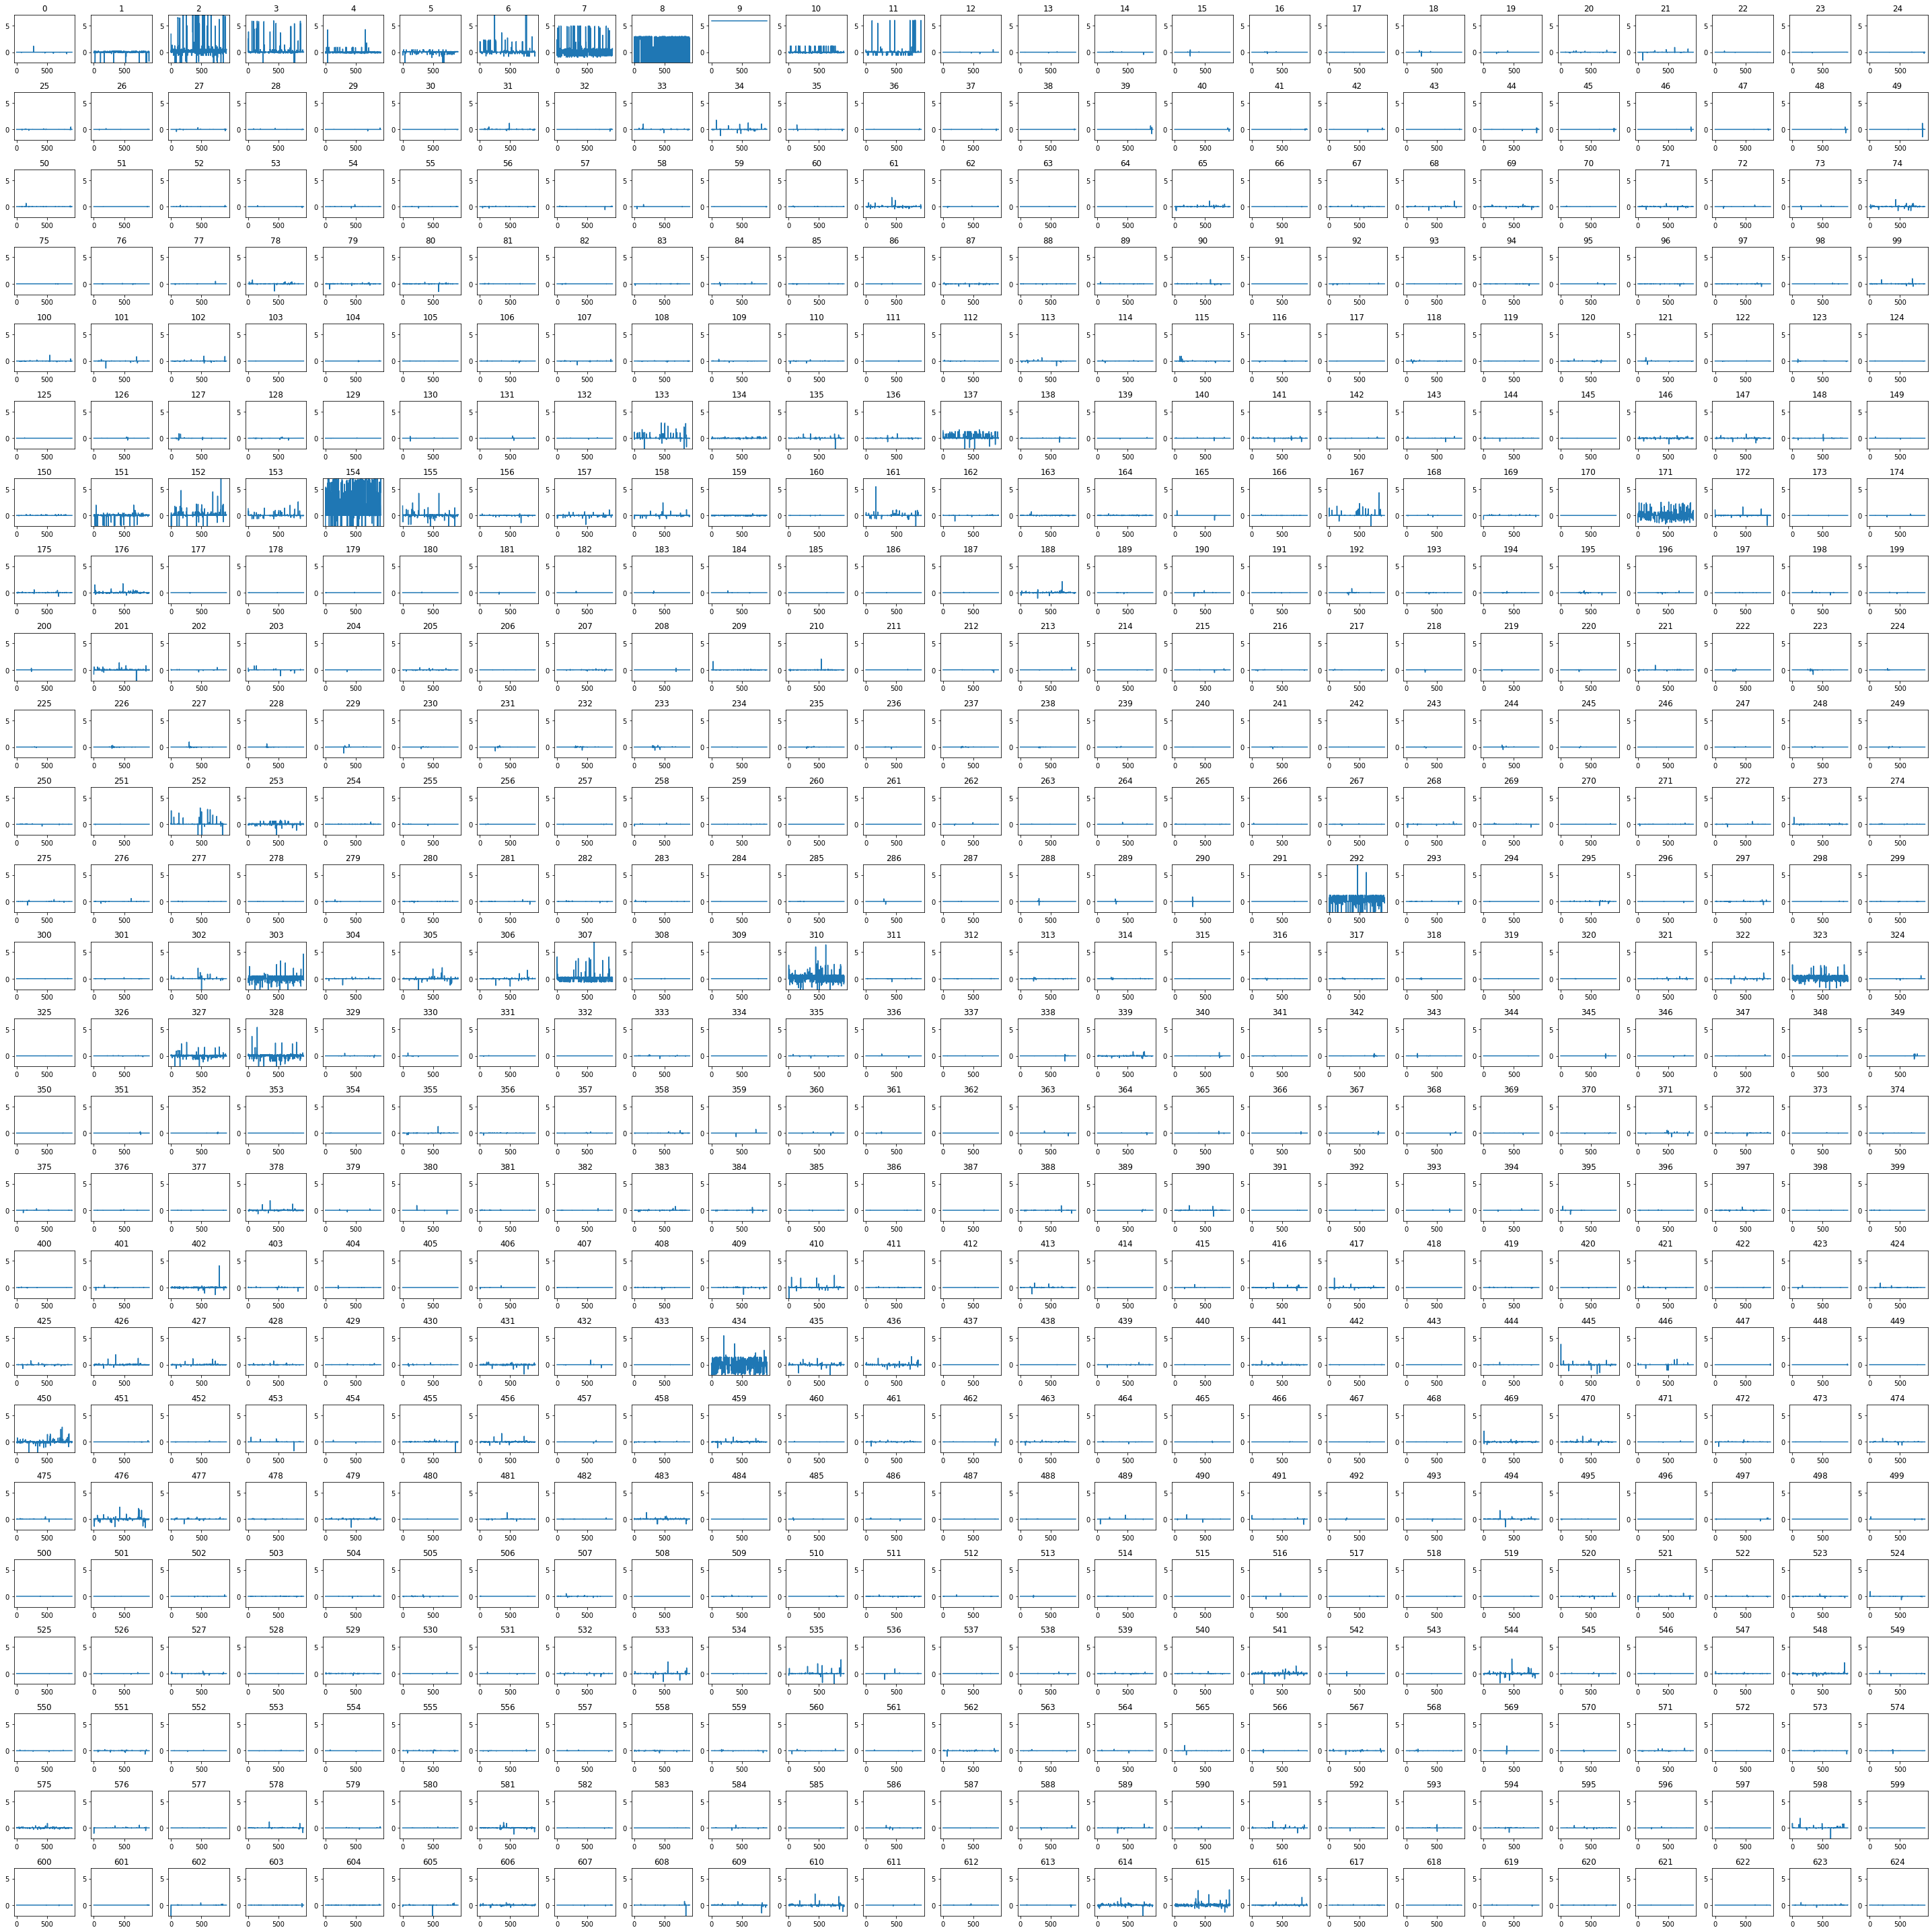

In [190]:
fig,ax =plt.subplots(25,25)
k=0
for i in range(25):
    for j in range(25):
        ax[i][j].plot((f @ np.outer(Ψ[:,k], Ψ[:,k])))
        ax[i][j].set_ylim([-2,7])
        ax[i][j].set_title(k)
        k=k+1
fig.set_figwidth(40)            
fig.set_figheight(40)
fig.tight_layout()        

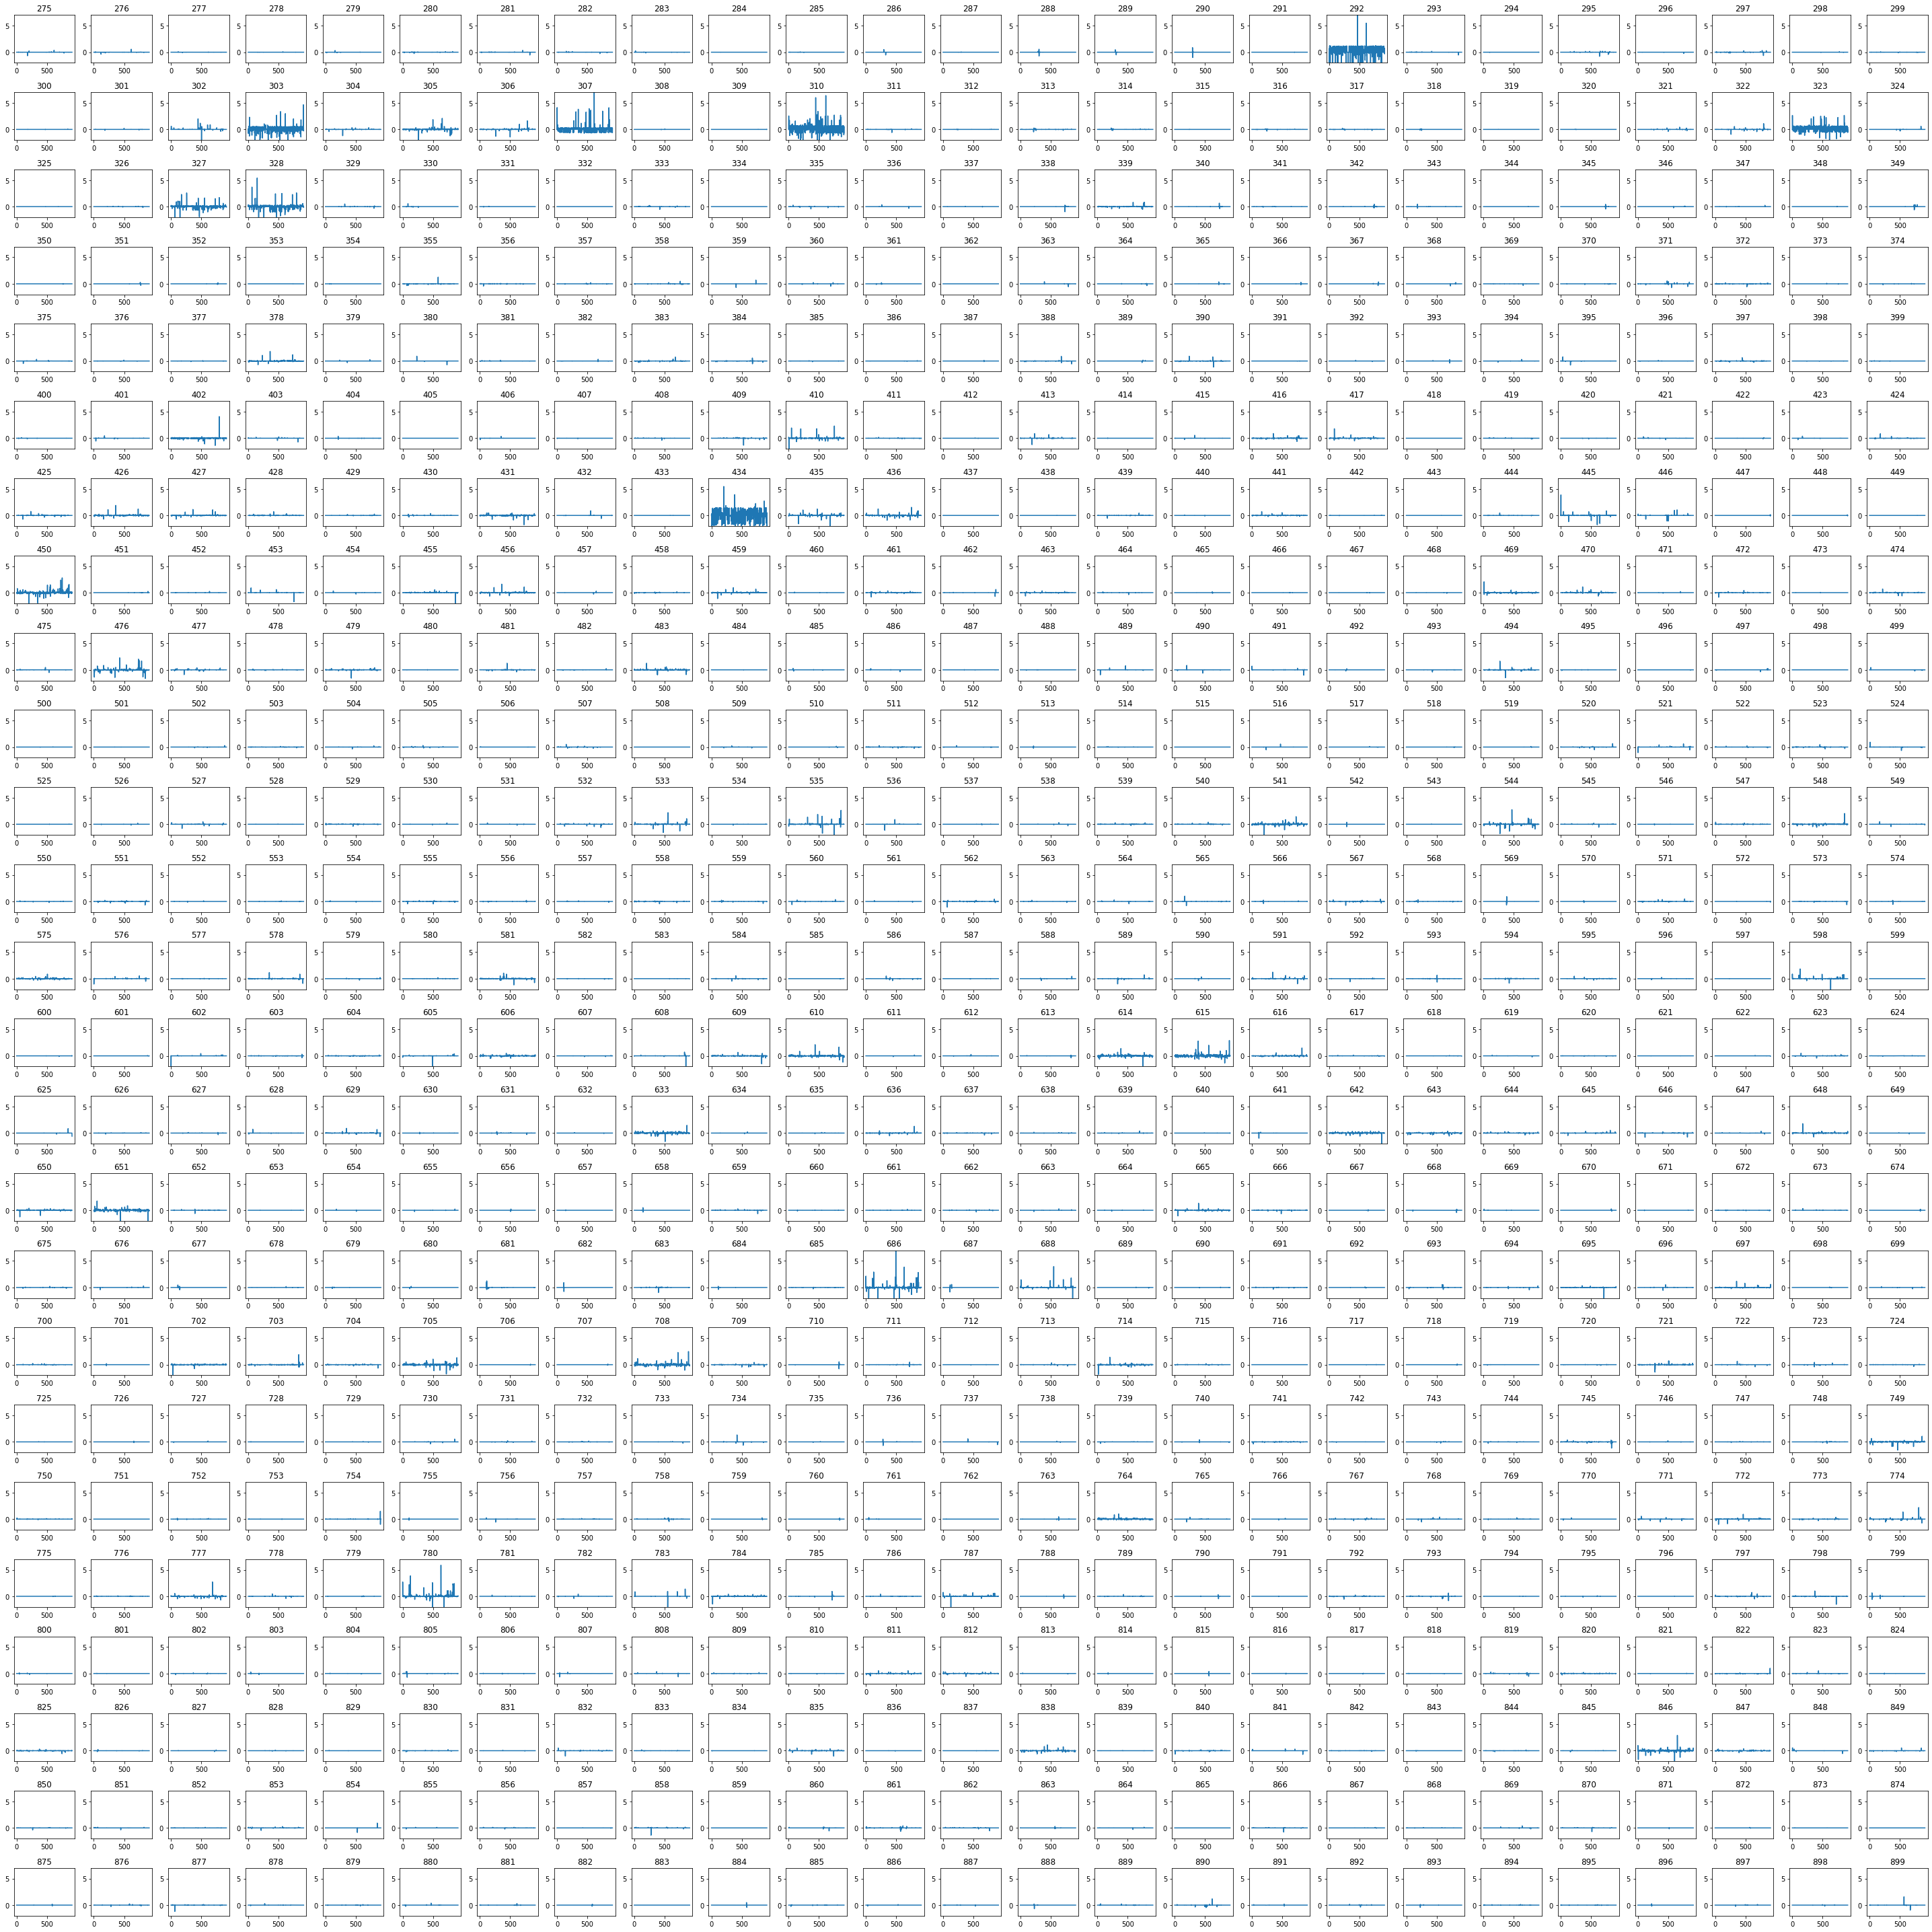

In [191]:
fig,ax =plt.subplots(25,25)
k=275
for i in range(25):
    for j in range(25):
        ax[i][j].plot((f @ np.outer(Ψ[:,k], Ψ[:,k])))
        ax[i][j].set_ylim([-2,7])
        ax[i][j].set_title(k)
        k=k+1
fig.set_figwidth(40)            
fig.set_figheight(40)
fig.tight_layout()        

평균을 나타내는 component

In [278]:
np.mean(f)

5.907710032601913

In [279]:
np.mean(f @ np.outer(Ψ[:,9], Ψ[:,9]))

5.907710032602384

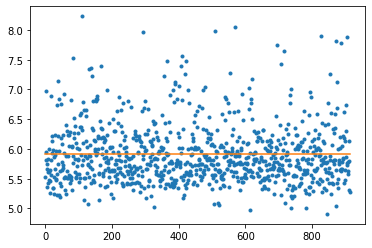

In [277]:
plt.plot(f,'.')
plt.plot(f @ np.outer(Ψ[:,9], Ψ[:,9]))

In [266]:
comphat = f @ np.outer(Ψ[:,2], Ψ[:,2]) + f @ np.outer(Ψ[:,3], Ψ[:,3]) + f @ np.outer(Ψ[:,7], Ψ[:,7]) + f @ np.outer(Ψ[:,8], Ψ[:,8]) + f @ np.outer(Ψ[:,11], Ψ[:,11]) + \
            f @ np.outer(Ψ[:,303], Ψ[:,303]) + f @ np.outer(Ψ[:,154], Ψ[:,154]) + f @ np.outer(Ψ[:,292], Ψ[:,292]) + f @ np.outer(Ψ[:,434], Ψ[:,434])

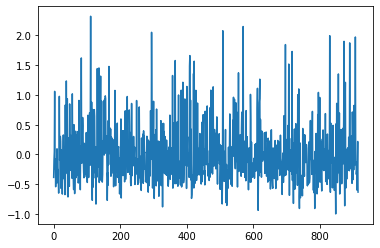

In [283]:
plt.plot(f-np.mean(f))

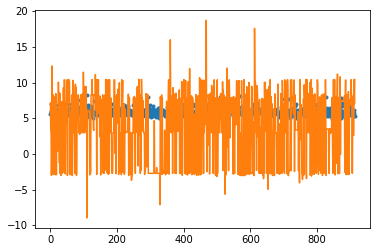

In [281]:
plt.plot(f,'.')
plt.plot(comphat)